## Quantum Fourier Transform
- The quantum Fourier transform (QFT) is the quantum implementation of the discrete Fourier transform over the amplitudes of a wavefunction
<img src = 'image1.png'>

- Basically the QFT acts on the **amplitudes** of the quantum state and then maps it into the **discrete fourier transform**
-  Note that only the amplitudes of the state were affected by this transformation.

## Intuition
- The quantum Fourier transform (QFT) transforms between two bases, the computational (Z) basis, and the Fourier basis. The H-gate is the single-qubit QFT, and it transforms between the Z-basis states  |0⟩ and |1⟩ to the X-basis states |+⟩ and |−⟩.

| (**State in the computational basis) -> QFT -> (State in the Fourier Basis) |**
- In binary we store the information in the form of up or down in the computational basis. In fourier basis, we actually store the information in the **angle by which our qubit is rotated about the z axis**


### Representing the binary numbers in the fourier basis
<img src='fourierbasis-counting.gif'>

In [1]:
from qiskit import * 
from qiskit.tools.visualization import plot_histogram,plot_bloch_multivector
from random import getrandbits
%matplotlib inline 

- Discovered something - 
$$ e^{(2\pi i)(\frac{x}{2^{k}})} $$
- In the above term, since x is obv a binary representation, so it doesn't really make sense
- What **X/(2^k)** means is - 
    $$ Given\ x = |x_{n}x_{n-1}...x_{1} \rangle , $$
    $$ \frac {x}{2^{k}} = \frac{x_{k}}{2} + \frac{x_{k-1}}{2^{2}} + ... + \frac {x_{1}}{2^{k}} $$
    
- NOW it makes sense!

## A 3- qubit QFT

In [2]:
binary_state = ""
for i in range(3):
    b = getrandbits(1)
    binary_state+= str(b)

print("Random state is :",binary_state)

Random state is : 011


- Create QC for this state

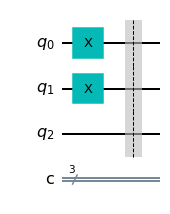

In [8]:
qc = QuantumCircuit(3,3)
# need to reverse due to the endianess of qiskit
for i,k in enumerate(binary_state[::-1]):
    if k == '1':
        qc.x(i)
qc.barrier()
qc.draw('mpl')

- Defining a CROT(k) gate - it is actually a RZ gate only with the angle as -
$$ \frac {2 \pi}{2^{k}}$$

### Implementation - cu1 gate

<img src='controlled_u.png'>

In [9]:
def rot_k(k):
    # returns the angle for the Cz gate 
    angle = (2*(np.pi))/(2**k)
    return angle

- **BASIC APPROACH** - Apply a hadamard to the qubit k and then start applying CROTi i ->[1,k] conditional on the qubits 
- Applying Hadamard to q1 and then q2 -> q1(crot2) and q3 -> q1(crot3) 

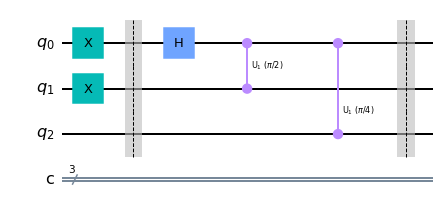

In [10]:
qc.h(0)
rot_21 = rot_k(2)
qc.cu1(rot_21,1,0)
rot_31 = rot_k(3)
qc.cu1(rot_31,2,0)
qc.barrier()
qc.draw('mpl')

- Applying hadamard to q2 and a crot(2) from q3 -> q2 

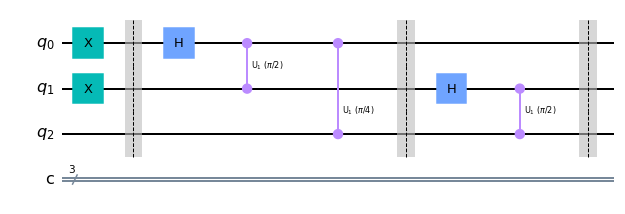

In [11]:
qc.h(1)
angle_32 = rot_k(2)
qc.cu1(angle_32,2,1)
qc.barrier()
qc.draw('mpl')

- Finally, apply the hadamard on q3 to complete the circuit

In [12]:
qc.h(2)
qc.barrier()
# qc.swap(0,2)
# qc.measure([0,1,2],[0,1,2])

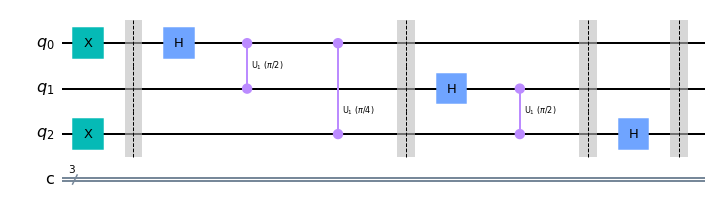

In [73]:
qc.draw('mpl')

In [13]:
backend = Aer.get_backend('statevector_simulator')
state = execute(qc,backend=backend).result().get_statevector()

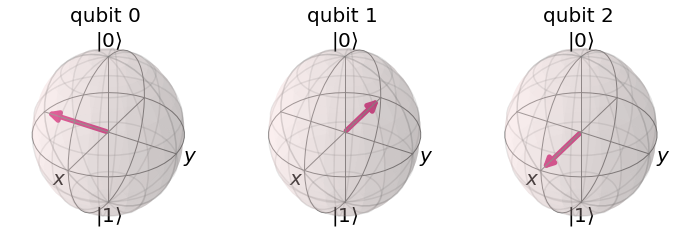

In [14]:
plot_bloch_multivector(state)

## Problem 1
- Trying out QFT for decimal 4

In [78]:
state = bin(4)[2:]
print("State is :",state)

State is : 100


- Building the circuit

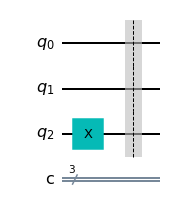

In [80]:
qc = QuantumCircuit(3,3)
for i,k in enumerate(state[::-1]):
    if k == '1':
        qc.x(i)
qc.barrier()
qc.draw('mpl')

- Building the Quantum Fourier transform

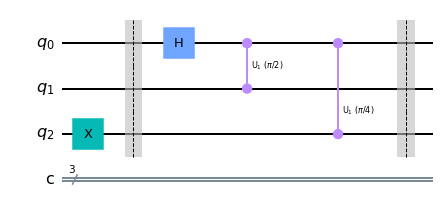

In [81]:
## STEP1
qc.h(0)
angle_21 = rot_k(2)
qc.cu1(angle_21,1,0)
angle_31 = rot_k(3)
qc.cu1(angle_31,2,0)
qc.barrier()
qc.draw('mpl')

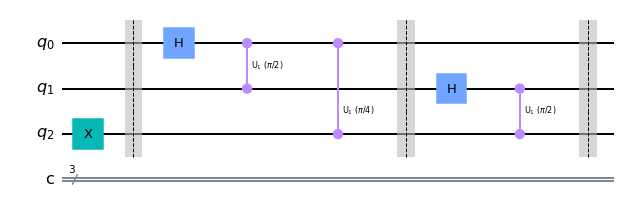

In [82]:
## STEP2
qc.h(1)
angle_32 = rot_k(2)
qc.cu1(angle_32,2,1)
qc.barrier()
qc.draw('mpl')

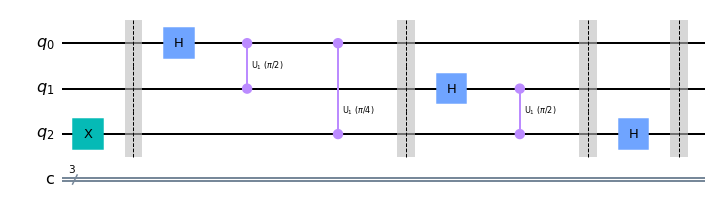

In [83]:
## STEP 3
qc.h(2)
qc.barrier()
qc.draw('mpl')

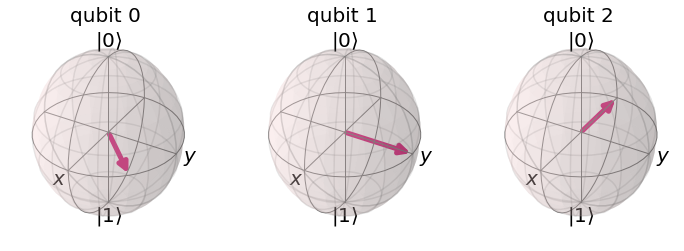

In [84]:
state = execute(qc,backend = backend).result().get_statevector()
plot_bloch_multivector(state)

## Problem 2
- Trying out qft for decimal 3

In [90]:
state = bin(3)[2:].zfill(3)
print("State is :",state)

State is : 011


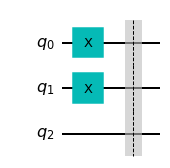

In [94]:
qc = QuantumCircuit(3)
for i,k in enumerate(state[::-1]):
    if k == '1':
        qc.x(i)
qc.barrier()
qc.draw('mpl')

- Building QFT circuit

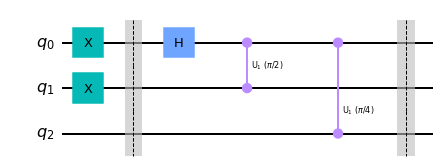

In [95]:
# STEP1 
qc.h(0)
angle_21 = rot_k(2)
qc.cu1(angle_21,1,0)
angle_31 = rot_k(3)
qc.cu1(angle_31,2,0)
qc.barrier()
qc.draw('mpl')

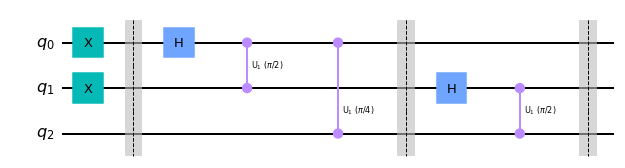

In [96]:
qc.h(1)
angle_32 = rot_k(2)
qc.cu1(angle_32,2,1)
qc.barrier()
qc.draw('mpl')

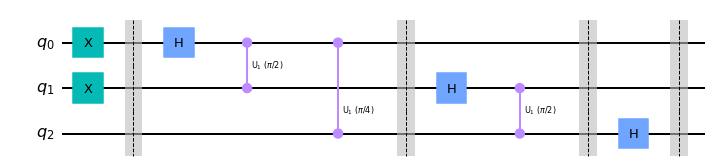

In [97]:
# STEP3 
qc.h(2)
qc.barrier()
qc.draw('mpl')

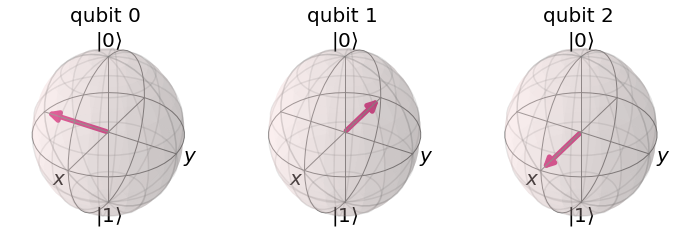

In [98]:
state = execute(qc,backend = backend).result().get_statevector()
plot_bloch_multivector(state)

## Writing Generalized QFT for n-qubits

In [43]:
def QFT(n_qubits):
    # First generate UROTk for k = 1,2,.. n_qubits 
    rotations = {}
    for i in range(2,n_qubits+1):
        rotations[i] = rot_k(i)
    print(rotations)
    # form the qft circuit 
    qft = QuantumCircuit(n_qubits,name = 'QFT')
    
    # start with qubits 
    for i in range(n_qubits):
        qubit = i 
        
        qft.h(qubit)
        rot_count = 2
        for control in range(qubit+1,n_qubits):
            qft.cp(rotations[rot_count],control,qubit)
            rot_count+=1 
        qft.barrier()
    display(qft.draw('mpl'))
    return qft

- Defining a quantum circuit 

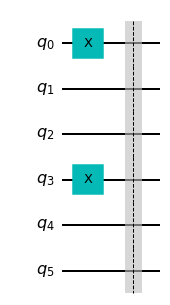

In [44]:
qc = QuantumCircuit(6)
qc.x(0)
qc.x(3)
qc.barrier()
qc.draw('mpl')

{2: 1.5707963267948966, 3: 0.7853981633974483, 4: 0.39269908169872414, 5: 0.19634954084936207, 6: 0.09817477042468103}


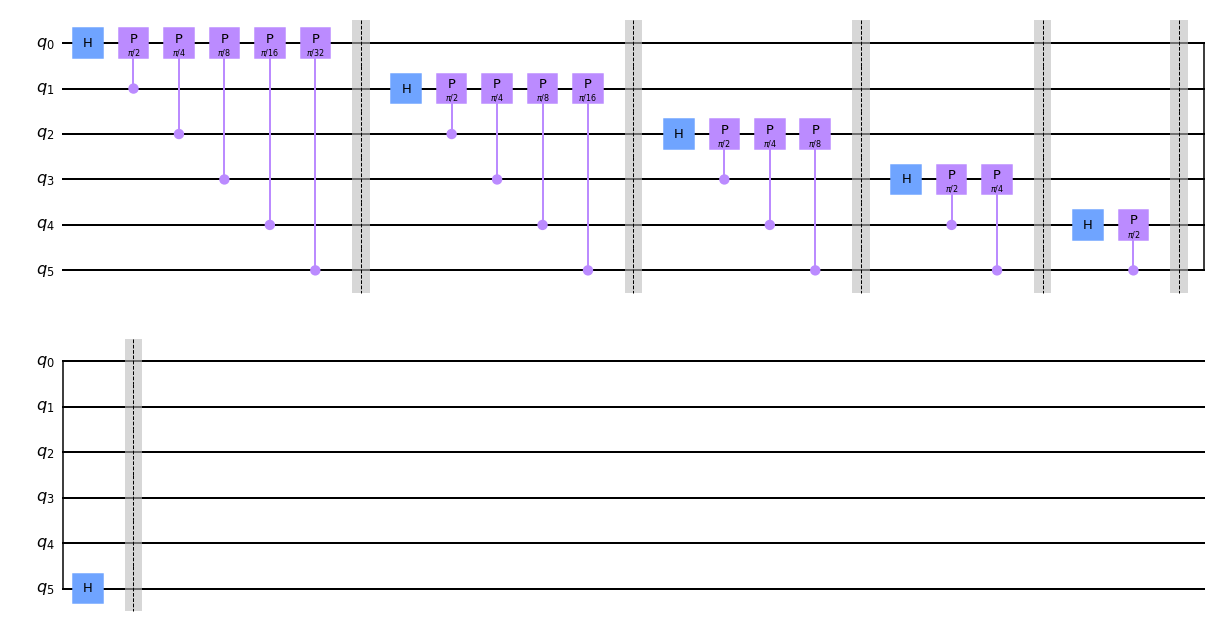

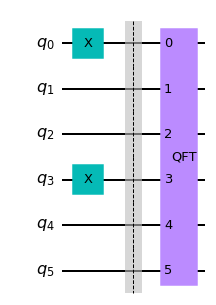

In [45]:
qft_circ = QFT(6)
qc.append(qft_circ,qc.qubits,qc.clbits)
qc.draw('mpl')

- Next, use this circuit in the QPE problem

- Again, a small note 
- The Q0 is the LSB and the Q5 is the MSB 
- 001001 -> this is the representation of the bit string and the Q5 is 0, Q4 is 0 , Q3 is 1 and so on...

## Writing Generalized Inverse QFT
- Writing inverse of qft is just applying the **MIRROR CIRCUIT** of the QFT.
- So, you will start with the right most gate

In [57]:
def inverse_QFT(n_qubits):
    # First generate UROTk for k = 1,2,.. n_qubits 
    rotations = {}
    for i in range(2,n_qubits+1):
        rotations[i] = rot_k(i)
    print(rotations)
    # form the qft circuit 
    inv_qft = QuantumCircuit(n_qubits,name = 'Inverse_QFT')
    
    # start with qubits 
    for i in range(n_qubits-1,-1,-1):
        qubit = i 
        
        rot_count = (n_qubits - 1) - qubit + 1 
        for control in range(n_qubits-1,qubit,-1):
            inv_qft.cp(-rotations[rot_count],control,qubit)
            rot_count-= 1 
        
        inv_qft.h(qubit)
        inv_qft.barrier()
    display(inv_qft.draw('mpl'))
    return inv_qft

## Testing circuit
- The resulting state MUST be same as the initial state

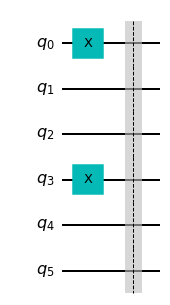

In [58]:
qc = QuantumCircuit(6)
qc.x(0)
qc.x(3)
qc.barrier()
qc.draw('mpl')

{2: 1.5707963267948966, 3: 0.7853981633974483, 4: 0.39269908169872414, 5: 0.19634954084936207, 6: 0.09817477042468103}


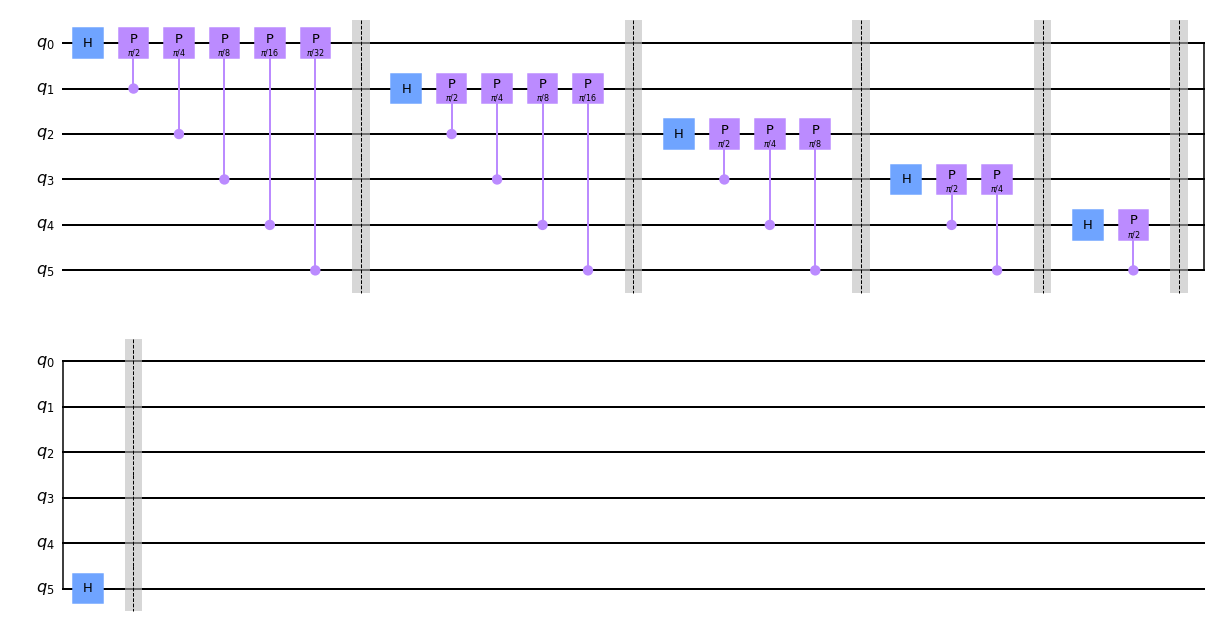

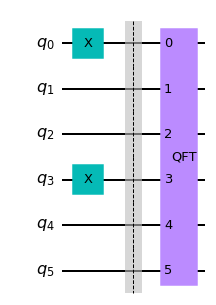

In [59]:
qft_circ = QFT(6)
qc.append(qft_circ,qc.qubits,qc.clbits)
qc.draw('mpl')

{2: 1.5707963267948966, 3: 0.7853981633974483, 4: 0.39269908169872414, 5: 0.19634954084936207, 6: 0.09817477042468103}


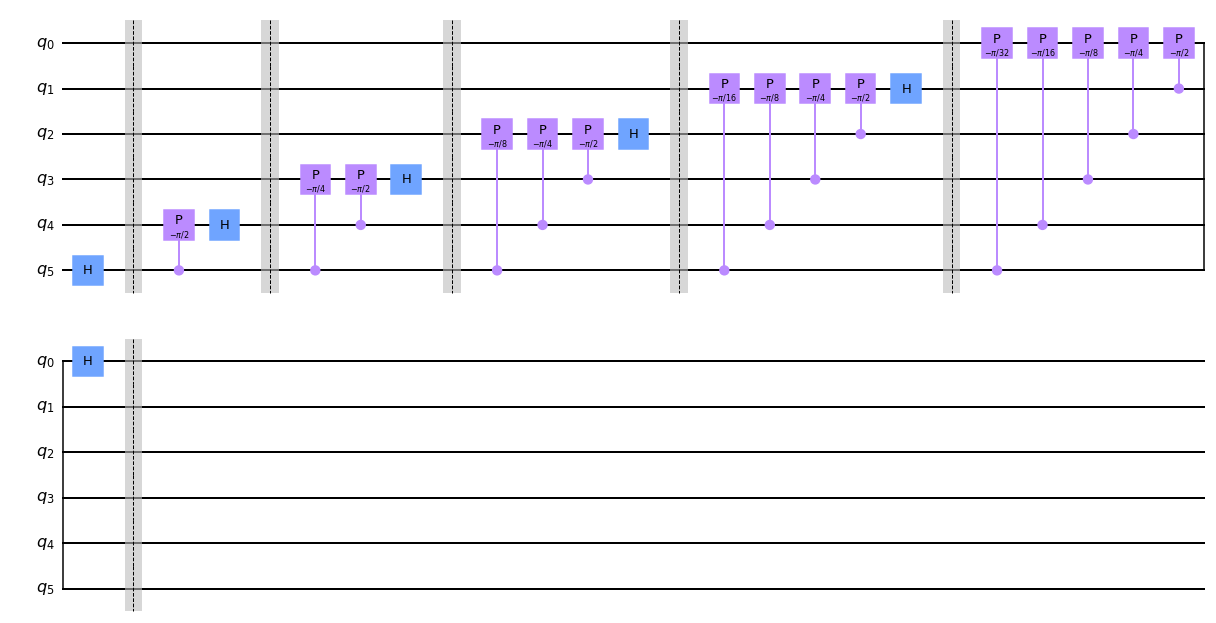

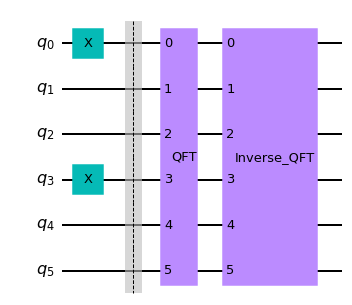

In [60]:
inv_qft = inverse_QFT(6)
qc.append(inv_qft,qc.qubits,qc.clbits)
qc.draw('mpl')

In [61]:
qc.measure_all()

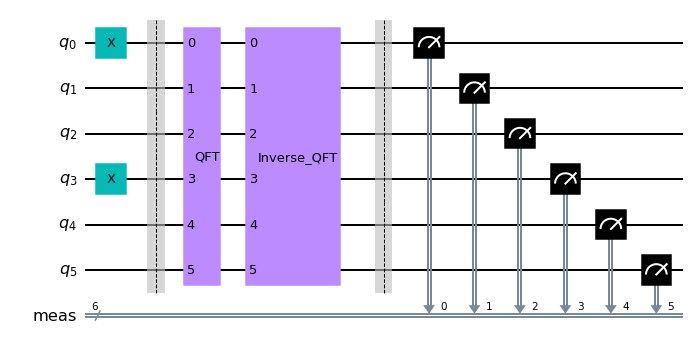

In [62]:
qc.draw('mpl')

In [63]:
backend = Aer.get_backend('qasm_simulator')
counts = execute(qc,backend = backend, shots=2**15).result().get_counts()
print("Counts of the final measurement :",counts)

Counts of the final measurement : {'001001': 32768}


## Testing with QuantumCircuit.inverse() function
- Qiskit provides a very nice way to invert a circuit by just using QuantumCircuit.inverse() 
- Has the same workings as your inverse QFT function

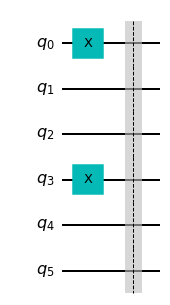

In [53]:
qc = QuantumCircuit(6)
qc.x(0)
qc.x(3)
qc.barrier()
qc.draw('mpl')

{2: 1.5707963267948966, 3: 0.7853981633974483, 4: 0.39269908169872414, 5: 0.19634954084936207, 6: 0.09817477042468103}


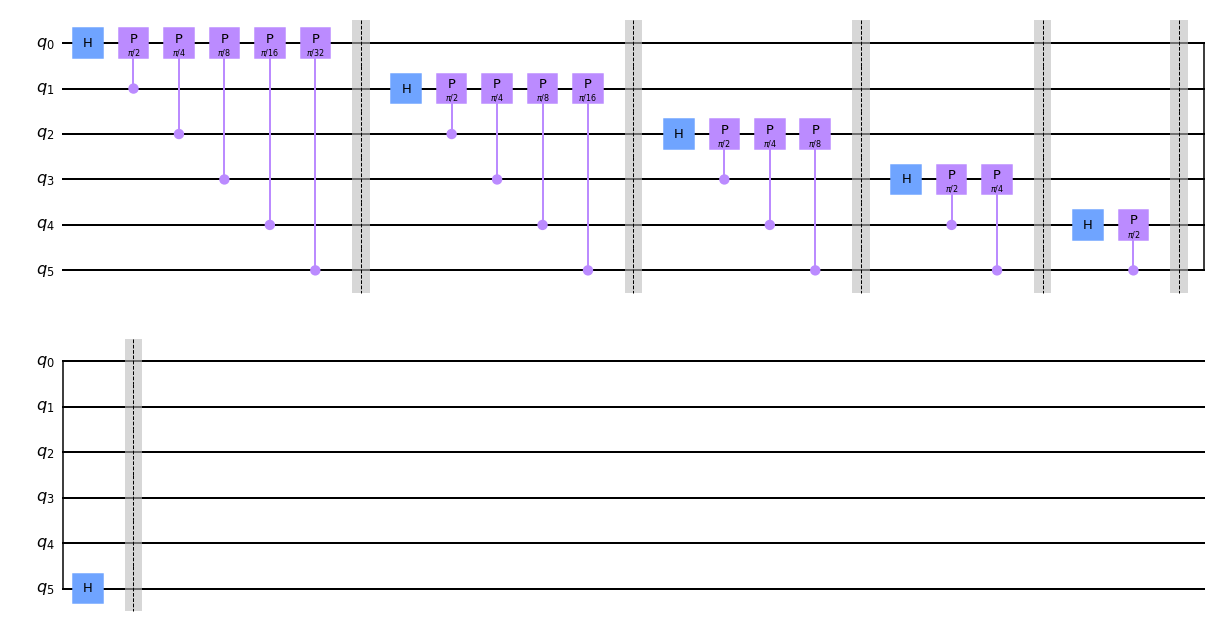

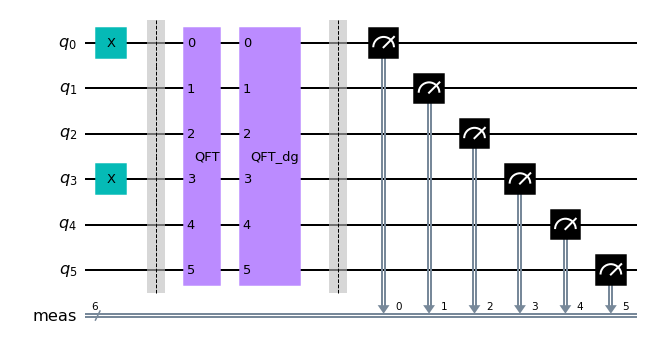

In [54]:
qft = QFT(6)
inv_qft = qft.inverse()
qc.append(qft,qc.qubits,qc.clbits)
qc.append(inv_qft,qc.qubits,qc.clbits)
qc.measure_all()
qc.draw('mpl')

In [55]:
counts = execute(qc,backend = backend,shots=2**15).result().get_counts()
print("Counts of the circuit :",counts)

Counts of the circuit : {'001001': 32768}


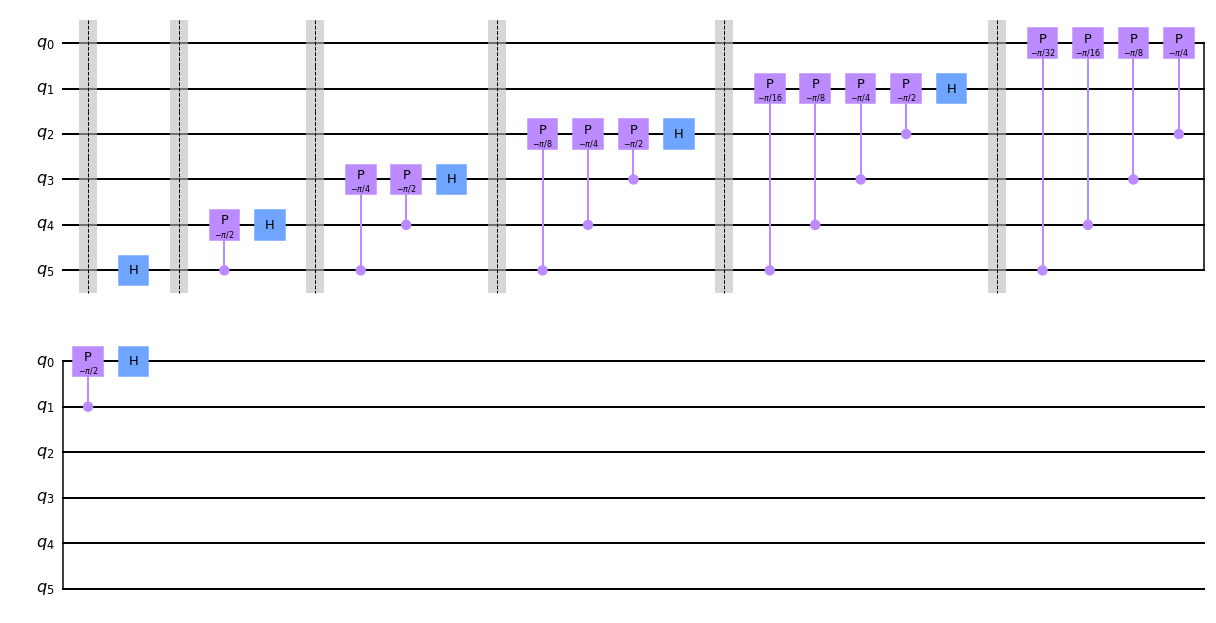

In [56]:
inv_qft.draw('mpl')

- This is OKAY :)